In [1]:
#Compare convective parameters from BARPA (forced with ERAI) with BARRA

#NOTE also check ERA5

import xarray as xr
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
from dask.diagnostics import ProgressBar
from distributed import Client
from barpa_read import drop_duplicates

In [2]:
start_lat = -44; end_lat = -10; start_lon = 130; end_lon = 156
m = Basemap(llcrnrlon = start_lon, llcrnrlat = start_lat, urcrnrlon = end_lon, \
    urcrnrlat = end_lat, projection="cyl", resolution = "l")

In [3]:
def load(v):
    f = xr.open_mfdataset("/g/data/eg3/ab4502/ExtremeWind/aus/threshold_data/barpa_erai_"+v+"_6hr_mean.nc", combine="by_coords")
    a = xr.open_mfdataset("/g/data/eg3/ab4502/ExtremeWind/aus/threshold_data/barpa_access_"+v+"_6hr_mean.nc", combine="by_coords")
    a1 = drop_duplicates(xr.open_mfdataset("/g/data/eg3/ab4502/ExtremeWind/aus/ACCESS1-0/ACCESS1-0_historical_r1i1p1_*.nc", combine="nested", concat_dim="time"))    
    g = xr.open_mfdataset("/g/data/eg3/ab4502/ExtremeWind/aus/threshold_data/barra_fc_"+v+"_6hr_mean.nc", combine="by_coords")
    e = xr.open_mfdataset("/g/data/eg3/ab4502/ExtremeWind/aus/threshold_data/era5_"+v+"_6hr_mean.nc", combine="by_coords")
    ei = xr.open_mfdataset("/g/data/eg3/ab4502/ExtremeWind/aus/threshold_data/erai_"+v+"_6hr_mean.nc", combine="by_coords")
    return [f,a,a1,g,e,ei]

In [12]:
def plot(f, a, a1, g, e, ei, v, vmin, vmax, t):
    plt.figure(figsize=[8,10]);plt.subplot(3,2,1);
    f.sel({"time":t})[v].mean("time").plot(vmin=vmin, vmax=vmax, robust=True)
    m.drawcoastlines(); plt.title("BARPA-ERAI")
    #g = g[v].sel({"time":t}).sel({"lat":slice(f.lat.values.min(), f.lat.values.max()), "lon":slice(f.lon.values.min(), f.lon.values.max())})
    #plt.subplot(3,2,2);g.mean("time").interp({"lat":f.lat, "lon":f.lon}).plot(vmin=vmin, vmax=vmax, robust=True)
    #m.drawcoastlines(); plt.title("BARRA")
    e = e[v].sel({"time":t}).sel({"lat":slice(f.lat.values.max(), f.lat.values.min()), "lon":slice(f.lon.values.min(), f.lon.values.max())})
    plt.subplot(3,2,3);e.mean("time").interp({"lat":f.lat, "lon":f.lon}).plot(vmin=vmin, vmax=vmax, robust=True)
    #m.drawcoastlines(); plt.title("ERA5")
    #plt.subplot(3,2,4);a.sel({"time":t})[v].mean("time").plot(vmin=vmin, vmax=vmax, robust=True)
    #m.drawcoastlines(); plt.title("BARPA-ACCESS")
    #plt.subplot(3,2,5);
    #a1 = a1[v].sel({"time":t})
    #a1.mean("time").interp({"lat":f.lat, "lon":f.lon}).plot(vmin=vmin, vmax=vmax, robust=True)
    #m.drawcoastlines(); plt.title("ACCESS1-0")
    plt.subplot(3,2,3);ei[v].mean("time").interp({"lat":f.lat, "lon":f.lon}).plot(vmin=vmin, vmax=vmax, robust=True)
    m.drawcoastlines(); plt.title("ERA-I")    
    plt.suptitle(v)
    plt.subplots_adjust(wspace=0.1, hspace=0.3)
    plt.savefig("/g/data/eg3/ab4502/figs/barpa/mean_clim_"+v+".png", bbox_inches="tight")
    
def plot_ts(f, a, a1, g, e, ei, v,t):
    plt.figure(figsize=[12,6])
    g[v].sel({"time":t}).interp({"lat":f.lat, "lon":f.lon}).resample({"time":'Q-Nov'}).mean("time").mean(("lat","lon")).plot(label="BARRA", marker="x")
    e[v].sel({"time":t}).interp({"lat":f.lat, "lon":f.lon}).resample({"time":'Q-Nov'}).mean("time").mean(("lat","lon")).plot(label="ERA5", marker="x")
    f.sel({"time":t})[v].resample({"time":'Q-Nov'}).mean("time").mean((("lat","lon"))).plot(label="BARPA-ERAI", marker="x")
    a.sel({"time":t})[v].resample({"time":'Q-Nov'}).mean("time").mean((("lat","lon"))).plot(label="BARPA-ACCESS", marker="x")
    a1.sel({"time":t})[v].interp({"lat":f.lat, "lon":f.lon}).resample({"time":'Q-Nov'}).mean("time").mean((("lat","lon"))).plot(label="ACCESS1-0", marker="x")
    plt.title(v)
    plt.legend()
    plt.savefig("/g/data/eg3/ab4502/figs/barpa/clim_ts_"+v+".png", bbox_inches="tight")

def plot_seasonal_cycle(f, a, a1, g, e, ei, v,t):
    plt.figure(figsize=[6,6])
    #g[v].sel({"time":t}).interp({"lat":f.lat, "lon":f.lon}).groupby("time.month").mean(dim=xr.ALL_DIMS).plot(label="BARRA", marker="x")    
    e[v].sel({"time":t}).interp({"lat":f.lat, "lon":f.lon}).groupby("time.month").mean(dim=xr.ALL_DIMS).plot(label="ERA5", marker="x")    
    f[v].sel({"time":t}).groupby("time.month").mean(dim=xr.ALL_DIMS).plot(label="BARPA-ERAI", marker="x")    
    #a[v].sel({"time":t}).groupby("time.month").mean(dim=xr.ALL_DIMS).plot(label="BARRA-ACCESS", marker="x")
    #a1[v].sel({"time":t}).interp({"lat":f.lat, "lon":f.lon}).groupby("time.month").mean(dim=xr.ALL_DIMS).plot(label="ACCESS1-0", marker="x")    
    ei[v].sel({"time":t}).interp({"lat":f.lat, "lon":f.lon}).groupby("time.month").mean(dim=xr.ALL_DIMS).plot(label="ERA-I", marker="x")        
    plt.title(v)
    plt.legend()
    plt.savefig("/g/data/eg3/ab4502/figs/barpa/clim_seasonal_"+v+".png", bbox_inches="tight")

def plot_diurnal_cycle(v_list):
    f = xr.open_mfdataset("/g/data/eg3/ab4502/ExtremeWind/aus/barpa_erai/*.nc", combine="by_coords")
    e = xr.open_mfdataset("/g/data/eg3/ab4502/ExtremeWind/aus/era5/era5_*.nc", combine="by_coords")
    b = xr.open_mfdataset("/g/data/eg3/ab4502/ExtremeWind/aus/barra_fc/*.nc", combine="by_coords")
    a = xr.open_mfdataset("/g/data/eg3/ab4502/ExtremeWind/aus/barpa_access/*.nc", combine="by_coords")

    for v in v_list:
        print(v)
        plt.figure(figsize=[6,6])
        e[v].sel({"time":np.in1d(e["time.hour"],[0,6,12,18])}).sel({"time":slice("1990-01-01 00:00", "2015-12-31 18:00")}).interp({"lat":f.lat, "lon":f.lon}).groupby("time.hour").mean(xr.ALL_DIMS).plot(label="ERA5", marker="x", color="tab:orange")
        b[v].sel({"time":np.in1d(b["time.hour"],[0,6,12,18])}).sel({"time":slice("1990-01-01 00:00", "2015-12-31 18:00")}).interp({"lat":f.lat, "lon":f.lon}).groupby("time.hour").mean(xr.ALL_DIMS).plot(label="BARRA", marker="x", color="tab:blue")
        f[v].sel({"time":np.in1d(f["time.hour"],[0,6,12,18])}).sel({"time":slice("1990-01-01 00:00", "2015-12-31 18:00")}).groupby("time.hour").mean(xr.ALL_DIMS).plot(label="BARPA-ERAI", marker="x", color="tab:green")       
        a[v].sel({"time":np.in1d(a["time.hour"],[0,6,12,18])}).sel({"time":slice("1990-01-01 00:00", "2015-12-31 18:00")}).groupby("time.hour").mean(xr.ALL_DIMS).plot(label="BARPA-ACCESS", marker="x", color="tab:red")
        plt.savefig("/g/data/eg3/ab4502/figs/barpa/clim_diurnal_"+v+".png", bbox_inches="tight")


In [5]:
f, a, a1, g, e = load("lr36")
plot(f, a, a1, g, e, "lr36", t=slice("1990-01-01 00:00", "2015-12-31 18:00"))
plot_ts(f, a, a1, g, e, "lr36", slice("1990-01-01 00:00", "2015-12-31 18:00"))
plot_seasonal_cycle(f, a, a1, g, e, "lr36", slice("1990-01-01 00:00", "2015-12-31 18:00"))

OSError: no files to open

/g/data/eg3/ab4502/miniconda3/envs/wrfpython3.6/lib/python3.6/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data/eg3/ab4502/miniconda3/envs/wrfpython3.6/lib/python3.6/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


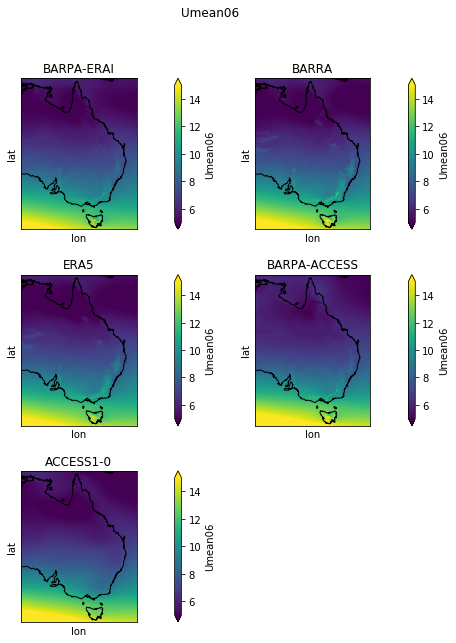

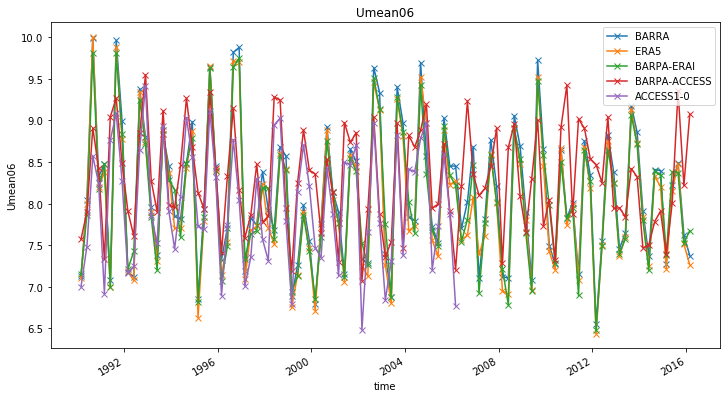

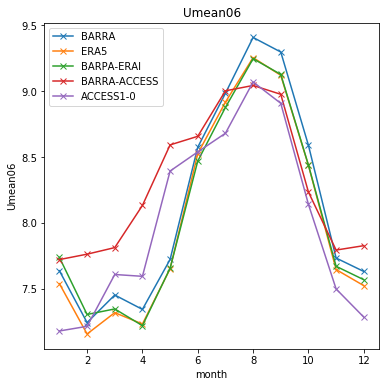

In [53]:
f, a, a1, g, e = load("Umean06")
plot(f, a, a1, g, e, "Umean06", vmin=5, vmax=15, t=slice("1990-01-01 00:00", "2015-12-31 18:00"))
plot_ts(f, a, a1, g, e, "Umean06", slice("1990-01-01 00:00", "2015-12-31 18:00"))
plot_seasonal_cycle(f, a, a1, g, e, "Umean06", slice("1990-01-01 00:00", "2015-12-31 18:00"))

/g/data/eg3/ab4502/miniconda3/envs/wrfpython3.6/lib/python3.6/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


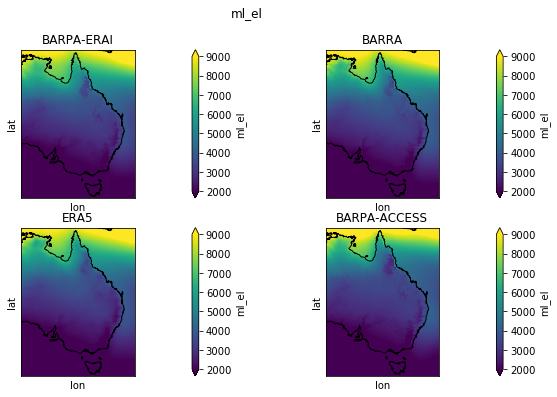

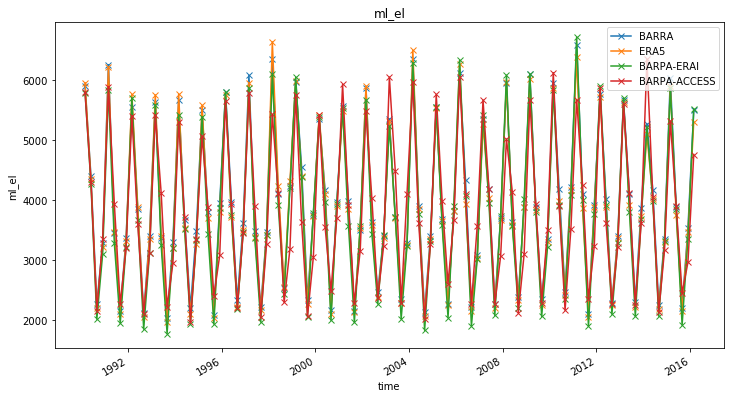

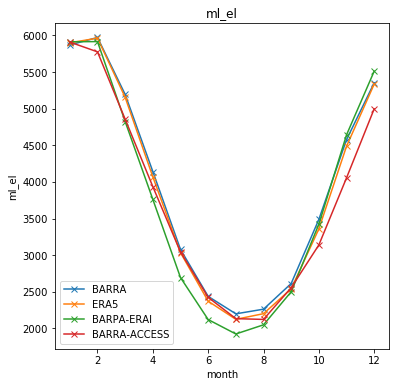

In [66]:
f, a, a1, g, e = load("ml_el")
plot(f, a, a1, g, e, "ml_el", vmin=2000, vmax=9000, t=slice("1990-01-01 00:00", "2015-12-31 18:00"))
plot_ts(f, a, a1, g, e, "ml_el", slice("1990-01-01 00:00", "2015-12-31 18:00"))
plot_seasonal_cycle(f, a, a1, g, e, "ml_el", slice("1990-01-01 00:00", "2015-12-31 18:00"))

/g/data/eg3/ab4502/miniconda3/envs/wrfpython3.6/lib/python3.6/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


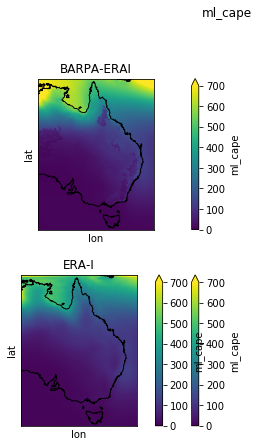

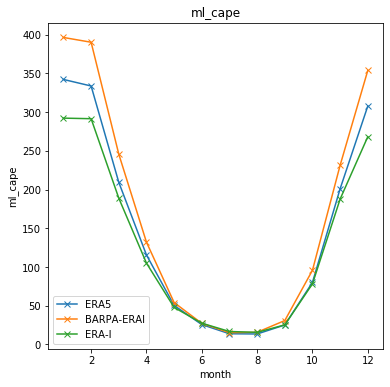

In [13]:
f, a, a1, g, e, ei = load("ml_cape")
plot(f, a, a1, g, e, ei, "ml_cape", vmin=0, vmax=700, t=slice("1990-01-01 00:00", "2015-12-31 18:00"))
#plot_ts(f, a, a1, g, e, "ml_cape", slice("1990-01-01 00:00", "2015-12-31 18:00"))
plot_seasonal_cycle(f, a, a1, g, e, ei, "ml_cape", slice("1990-01-01 00:00", "2015-12-31 18:00"))

/g/data/eg3/ab4502/miniconda3/envs/wrfpython3.6/lib/python3.6/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data/eg3/ab4502/miniconda3/envs/wrfpython3.6/lib/python3.6/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


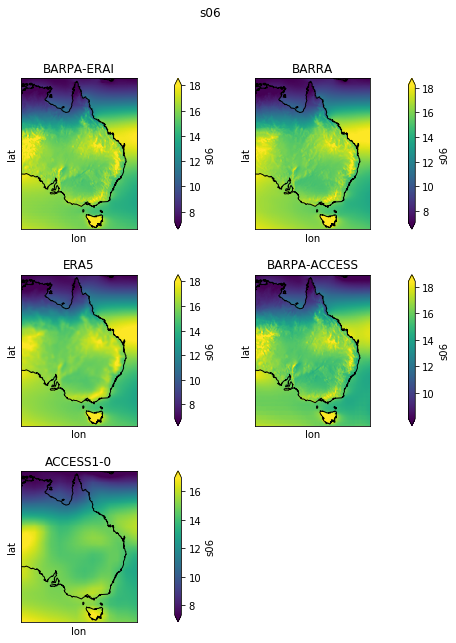

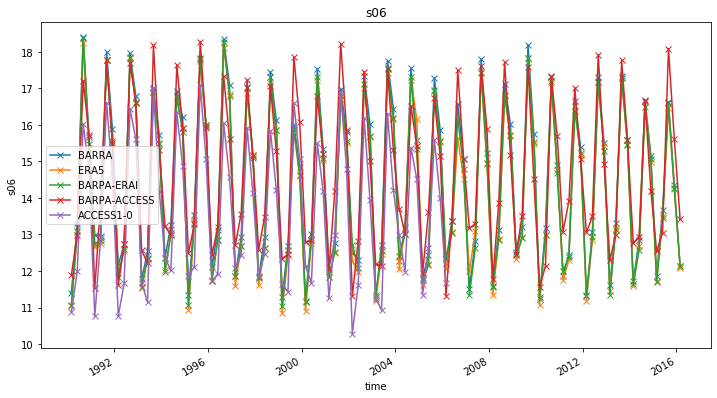

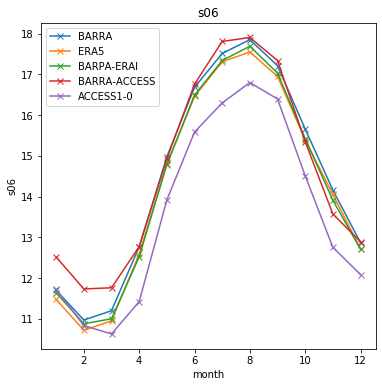

In [54]:
f, a, a1, g, e = load("s06")
plot(f, a, a1, g, e, "s06", vmin=None, vmax=None, t=slice("1990-01-01 00:00", "2015-12-31 18:00"))
plot_ts(f, a, a1, g, e, "s06", slice("1990-01-01 00:00", "2015-12-31 18:00"))
plot_seasonal_cycle(f, a, a1, g, e, "s06", slice("1990-01-01 00:00", "2015-12-31 18:00"))

In [43]:
plot_diurnal_cycle(["ml_cape"])

KeyboardInterrupt: 

In [13]:
a1 = xr.open_mfdataset("/g/data/eg3/ab4502/ExtremeWind/aus/ACCESS1-0/ACCESS1-0_historical_r1i1p1_*")

/g/data/eg3/ab4502/miniconda3/envs/wrfpython3.6/lib/python3.6/site-packages/xarray/backends/api.py:783: FutureWarning: In xarray version 0.13 `auto_combine` will be deprecated.
  coords=coords)
/g/data/eg3/ab4502/miniconda3/envs/wrfpython3.6/lib/python3.6/site-packages/xarray/backends/api.py:783: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset` to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in in future, please use the
new `combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  coords=coords)


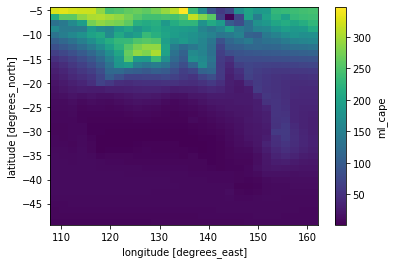

In [14]:
a1["ml_cape"].mean("time").plot()